In [ ]:
import numpy as np
import collections
import typing

import tensorflow.compat.v1 as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import random
from collections import deque
import time


In [ ]:
tf.disable_v2_behavior() # testing on tensorflow 1


In [ ]:
class Agent:
    def __init__(self, env, optimizer, batch_size):
        # general info
        self.state_size = env.observation_space.shape[0] # number of factors in the state; e.g: velocity, position, etc
        self.action_size = env.action_space.n
        self.optimizer = optimizer
        self.batch_size = batch_size
        
        # allow large replay exp space
        self.replay_exp = deque(maxlen=1000000)
        
        self.gamma = 0.99
        self.epsilon = 1.0 # initialize with high exploration, which will decay later
        
        # Build Policy Network
        self.brain_policy = Sequential()
        self.brain_policy.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.brain_policy.add(Dense(128 , activation = "relu"))
        self.brain_policy.add(Dense(self.action_size, activation = "linear"))
        self.brain_policy.compile(loss = "mse", optimizer = self.optimizer)
        
        
        # Build Target Network
        self.brain_target = Sequential()
        self.brain_target.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.brain_target.add(Dense(128 , activation = "relu"))
        self.brain_target.add(Dense(self.action_size, activation = "linear"))
        self.brain_target.compile(loss = "mse", optimizer = self.optimizer)
        
        
        self.update_brain_target()
    
    # add new experience to the replay exp
    def memorize_exp(self, state, action, reward, next_state, done):
        self.replay_exp.append((state, action, reward, next_state, done))

    def build_model(self):
        # a NN with 2 fully connected hidden layers
        model = Sequential()
        model.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        model.add(Dense(128 , activation = "relu"))
        model.add(Dense(self.action_size, activation = "linear"))
        model.compile(loss = "mse", optimizer = self.optimizer)
        
        return model
    
    def update_brain_target(self):
        return self.brain_target.set_weights(self.brain_policy.get_weights())
    
    def choose_action(self, state):
        if np.random.uniform(0.0, 1.0) < self.epsilon: # exploration
            action = np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, state_size])
            qhat = self.brain_policy.predict(state) # output Q(s,a) for all a of current state
            action = np.argmax(qhat[0]) # because the output is m * n, so we need to consider the dimension [0]
            
        return action
     
    # update params in NN
    def learn(self):
        """
        sample = random.choices(self.replay_exp, k = min(len(self.replay_exp), self.batch_size))
        
        
        states, actions, rewards, next_states, dones = map(list, zip(sample))
        
        # add exp to replay exp
        qhats_next = self.brain_target(next_states)
        
        # set all value actions of terminal state to 0
        qhats_next[dones] = np.zeros((self.action_size))
        
        q_targets = rewards + self.gamma * np.max(qhats_next, axis=1) # update greedily
        
        self.brain.update_nn(self.sess, states, actions, q_targets)
        
        """
        
        # take a mini-batch from replay experience
        cur_batch_size = min(len(self.replay_exp), self.batch_size)
        mini_batch = random.sample(self.replay_exp, cur_batch_size)
        
        # batch data
        sample_states = np.ndarray(shape = (cur_batch_size, self.state_size)) # replace 128 with cur_batch_size
        sample_actions = np.ndarray(shape = (cur_batch_size, 1))
        sample_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sample_next_states = np.ndarray(shape = (cur_batch_size, self.state_size))
        sample_dones = np.ndarray(shape = (cur_batch_size, 1))

        temp=0
        for exp in mini_batch:
            sample_states[temp] = exp[0]
            sample_actions[temp] = exp[1]
            sample_rewards[temp] = exp[2]
            sample_next_states[temp] = exp[3]
            sample_dones[temp] = exp[4]
            temp += 1
        
         
        sample_qhat_next = self.brain_target.predict(sample_next_states)
        
        # set all Q values terminal states to 0
        sample_qhat_next = sample_qhat_next * (np.ones(shape = sample_dones.shape) - sample_dones)
        # choose max action for each state
        sample_qhat_next = np.max(sample_qhat_next, axis=1)
        
        sample_qhat = self.brain_policy.predict(sample_states)
        
        for i in range(cur_batch_size):
            a = sample_actions[i,0]
            sample_qhat[i,int(a)] = sample_rewards[i] + self.gamma * sample_qhat_next[i]
            
        q_target = sample_qhat
            
        self.brain_policy.fit(sample_states, q_target, epochs = 1, verbose = 0)
        
            
            
        """
        
        for state, action, reward, next_state, done in mini_batch:
            target_Q_s_a = 0 # new target for Q(s,a)
            state = np.reshape(state, [1, state_size])
            next_state = np.reshape(next_state, [1, state_size])
            
            # if it is not the terminal state
            if not done:
                qhat_next = self.brain_target.predict(next_state)  # estimate Q(s',a')
                target_Q_s_a = reward + self.gamma * np.amax(qhat_next[0]) # because the output is m * n, so we need to consider the dimension [0]
            else:
                target_Q_s_a = reward
            
            target_output = self.brain_policy.predict(state) # we will replace target of Q(s,a) for specific a later
            target_output[0][action] = target_Q_s_a # new target for state s and action a
            
            self.brain_policy.fit(state, target_output, epochs = 1, verbose = 0)
            
        """

In [ ]:
!pip3 install box2d-py


     |████████████████████████████████| 450kB 17.0MB/s 


In [ ]:
import gym

env = gym.make('LunarLander-v2')
env.reset()



array([-0.00250769,  1.4135607 , -0.2540086 ,  0.11736678,  0.00291248,
        0.05753676,  0.        ,  0.        ], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

optimizer = Adam(learning_rate = 0.0001)

agent = Agent(env, optimizer, batch_size = 64)
state_size = env.observation_space.shape[0]

#state = env.reset()

#print(state.shape)

# load model
#agent.brain_policy.set_weights(tf.keras.models.load_model('C:/Users/nhunh/.spyder-py3/Model1.h5').get_weights())

In [ ]:
timestep=0
rewards = []
aver_reward = []
aver = deque(maxlen=100)
total_score_aver = 0

for episode in range(1000):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        
        # env.render()

        total_reward += reward
        
        agent.memorize_exp(state, action, reward, next_state, done)
        agent.learn()
        
        state = next_state
        timestep += 1
        
        
    aver.append(total_reward)     
    aver_reward.append(np.mean(aver))
    
    rewards.append(total_reward)
        
    # update model_target after each episode
    agent.update_brain_target()

    agent.epsilon = max(0.1, 0.995 * agent.epsilon) # decaying exploration
    
    total_score_aver += total_reward
    if ((episode + 1) % 100 == 0):
        aver_score = total_score_aver / 100
        print("Episode ", episode + 1, "Average Score: ", aver_score)
    
    """
    if episode % 50 == 0:
        agent.brain_policy.save("C:/Users/nhunh/.spyder-py3/Newest_update.h5")
    """
    


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode  100 Average Score:  -130.6536174878384
Episode  200 Average Score:  -213.90971408524894
Episode  300 Average Score:  -264.8930534368811
Episode  400 Average Score:  -296.5178197435907
Episode  500 Average Score:  -306.55792585655513
Episode  600 Average Score:  -142.29316003824044
Episode  700 Average Score:  103.9493934625809
Episode  800 Average Score:  355.76118680574785
Episode  900 Average Score:  575.277801923405
Episode  1000 Average Score:  810.1509270120716


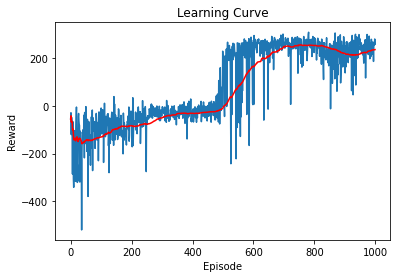

In [ ]:
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(rewards)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(aver_reward, 'r')

agent.brain_policy.save('C:/Users/nhunh/.spyder-py3/Model1.h5')